In [4]:
import pickle
import pandas as pd
import numpy as np

from typing import List
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

#the non-conservative DRD2 oracle is taken from TDC benchmark
#to install TDC via pip: pip install PyTDC (https://pypi.org/project/PyTDC/)
from tdc import Oracle

from HITL_AL_GOMG.synthitl.simulated_expert import EvaluationModel
from HITL_AL_GOMG.scoring.metrics import internal_diversity, novelty, SA, fraction_valid, fraction_unique, QED
from HITL_AL_GOMG.path import simulators, predictors, training
from HITL_AL_GOMG.utils import ecfp_generator

In [5]:
import os
import torch

import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
def set_matplotlib_params():

    """Set matplotlib params."""

    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams.update(
        {
            "font.size": 24,
            "lines.linewidth": 2,
            "axes.labelsize": 24,  # fontsize for x and y labels
            "axes.titlesize": 24,
            "xtick.labelsize": 20,
            "ytick.labelsize": 20,
            "legend.fontsize": 20,
            "axes.linewidth": 2,
            "text.usetex": False,  # use LaTeX to write all text
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.grid": False,
        })

set_matplotlib_params()

In [6]:
#conservative oracle (DRD2 activity cutoff is pIC50 of 7.3)
oracle = EvaluationModel("drd2", path_to_simulator=f"{simulators}/drd2.pkl")

#non-conservative oracle (DRD2 activity cutoff is pIC50 of 5, based on Olivecrona et al. (2017))
oracle_tdc = Oracle(name="DRD2")

100%|█████████████████████████████████████████████████████████| 35.4M/35.4M [00:07<00:00, 4.60MiB/s]
Done!


In [7]:
initial_drd2_qsar = pickle.load(open(f"{predictors}/drd2.pkl", "rb"))
herg_model = pickle.load(open(f"{simulators}/herg.pkl", "rb"))

In [8]:
herg_model

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', n_estimators=300)

In [9]:
initial_train_set = pd.read_csv(f"{training}/drd2_train.csv", index_col = 0)
initial_train_set_actives = initial_train_set[initial_train_set["target"] == 1]
initial_train_set_actives.shape

(30, 2)

In [10]:
fp_counter = ecfp_generator(radius=3, useCounts=True)

In [31]:
def calc_total_oracle_score(results, base = False):

    if base:
        smiles_list = results["last_outputs_base"].SMILES.tolist()
        qed_score = results["qed_base"][-1]
        all_qed_scores = results["all_qed_base"][-1]
        all_herg_scores = results["all_herg_base"][-1]
        preds = results["init_pred_base"][-1]
        novelty = results["novel_base"][-1]
        valid = results["valid_base"][-1]
        unique = results["unique_base"][-1]
        div = results["int_div_base"][-1]
    else:
        smiles_list = results["last_outputs"].SMILES.tolist()
        qed_score = results["qed"][-1]
        all_qed_scores = results["all_qed"][-1]
        all_herg_scores = results["all_herg"][-1]
        preds = results["updated_pred"]
        novelty = results["novel"][-1]
        valid = results["valid"][-1]
        unique = results["unique"][-1]
        div = results["int_div"][-1]
        
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    drd2_oracle_score = [oracle.oracle_score(s) for s in smiles_list]
    drd2_tdc_oracle_score = oracle_tdc(smiles_list)    
    
    sa_score_moses = [SA(m) for m in mols]
    qed_scores = [QED(m) for m in mols]
    herg_score = herg_model.predict_proba(fp_counter.get_fingerprints(smiles_list))[:,1].tolist()
    total_score_oracle_pred = (np.mean(drd2_oracle_score) + ( 1 - np.mean(herg_score)) + 0.5 * np.mean(qed_score))/(1+1+0.5)
    all_total_scores_oracle_pred = [(i[0] + 1-i[1] + 0.5*i[2])/(1+1+0.5) for i in zip(drd2_oracle_score, all_herg_scores, all_qed_scores)]
    total_score_oracle_tdc = (np.mean(drd2_tdc_oracle_score) + ( 1 - np.mean(herg_score)) + 0.5 * np.mean(qed_score))/(1+1+0.5)
    mae_predictor_oracle_pred = abs(np.mean(drd2_oracle_score) - np.mean(preds))
    mae_predictor_oracle_tdc = abs(np.mean(drd2_tdc_oracle_score) - np.mean(preds))
    
    print("Mean Total Score (conservative DRD2 Oracle):", total_score_oracle_pred, 
          "\nMean Total Score (non conservative DRD2 Oracle):", total_score_oracle_tdc,
          "\nMean DRD2 Oracle Score (conservative)", np.mean(drd2_oracle_score), 
          "\nMean DRD2 Oracle Score (non conservative)", np.mean(drd2_tdc_oracle_score), 
          "\nMean DRD2 Predicted Score", np.mean(preds), 
          "\nMean Absolute Error between Oracle (conservative) and Predicted", mae_predictor_oracle_pred,
          "\nMean Absolute Error between Oracle (non conservative) and Predicted", mae_predictor_oracle_tdc,
          "\nMean hERG Score", 1-np.mean(herg_score), 
          "\nMean QED Score", np.mean(qed_score), 
          "\nInternal Diversity Score", div, 
          "\nNovelty Score", novelty, 
          "\nValidity", valid,
          "\nUniqueness", unique,
          "\nSynthetic Accessibility Score", np.mean(sa_score_moses)
         )
    
    #return sa_score_moses, all_qed_scores, all_herg_scores, all_total_scores_oracle_pred

In [12]:
def mae_wrt_oracle(results, oracle_type = "conservative", top_molecules = 500):
    if oracle_type == "conservative":
        no_hitl_diff = [abs(i - j) for i,j in zip(
            [results["orc_pred_base"][0], results["orc_pred_base"][1], results["orc_pred_base"][2], results["orc_pred_base"][-1]], 
            [results["init_pred_base"][0], results["init_pred_base"][1], results["init_pred_base"][2], results["init_pred_base"][-1]]
        )]
        hitl_diff = [abs(i - j) for i,j in zip(
            [results["orc_pred"][0], results["orc_pred"][1], results["orc_pred"][2], results["orc_pred"][-1]], 
            [results["updated_pred"][0], results["updated_pred"][1], results["updated_pred"][2], results["updated_pred"][-1]]
        )]
    if oracle_type == "non_conservative":
        no_hitl_diff = [abs(i - j) for i,j in zip(
            [results["orc_tdc_base"][0], results["orc_tdc_base"][1], results["orc_tdc_base"][2], results["orc_tdc_base"][-1]], 
            [results["init_pred_base"][0], results["init_pred_base"][1], results["init_pred_base"][2], results["init_pred_base"][-1]]
        )]
        hitl_diff = [abs(i - j) for i,j in zip(
            [results["orc_tdc"][0], results["orc_tdc"][1], results["orc_tdc"][2], results["orc_tdc"][-1]], 
            [results["updated_pred"][0], results["updated_pred"][1], results["updated_pred"][2], results["updated_pred"][-1]]
        )]

    vals = [np.round(no_hitl_diff,2), np.round(hitl_diff,2)]

    labels = ["w/o chemist feedback", "w/ chemist feedback"]
    all_colors = ["orange", "blue"]

    # Create a figure with subplots
    fig, axes = plt.subplots(figsize=(12, 6))

    # First Row: Curves
    x = np.arange(4)  # Sample data for x-axis


    # Create an array of rounds for the x-axis
    rounds = np.arange(4)
    num_methods = 2

    # Set the width of the bars
    bar_width = 0.25

    # Create bars for each method in data1 and add error bars
    for i, v in enumerate(vals):
        axes.bar(
            rounds + (i + 1) * bar_width,
            v,
            width=bar_width,
            label=labels[i],
            alpha=0.9,
            color=all_colors[i]
        )

    # Set labels and title
    axes.set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
    axes.set_xticklabels(np.arange(4))

    axes.legend()
    axes.set_xlabel("HITL iterations \n (50 molecules evaluated at each iteration)")
    axes.set_ylabel("MAE between Predicted and Oracle probabilities")
    axes.set_title(f"Best {top_molecules} high-scored molecules according to Total Score \n ({oracle_type} Oracle)")

In [22]:
def get_hitl_results(
    path_to_results_folder, 
    path_to_baseline, 
    path_to_initial_pool,
    n_iters = 3, 
    top_molecules = 500, 
    sorting_score = "total_score",
    sorting_score_base = "total_score",
    drd2_name = "DRD2"
):
    
    outputs_smiles = []
    outputs_base_smiles = []
    
    all_init_pred_base = []
    all_updated_pred = []
    all_orc_pred, all_orc_pred_base = [], []
    all_orc_tdc, all_orc_tdc_base = [], []
    all_qed, all_qed_base = [], []
    all_herg, all_herg_base = [], []

    init_pred, init_pred_base = [], []
    updated_pred = []
    human_pred = []
    human_pred_score = []
    orc_pred, orc_pred_base = [], []
    orc_tdc, orc_tdc_base = [], []
    qed, qed_base = [], []
    herg, herg_base = [], []
    int_div, int_div_base = [], []
    valid, valid_base = [], []
    unique, unique_base = [], []
    novel, novel_base = [], []
    pairwise_sim = []

    for i in range(n_iters + 1):
        print(i)
        if i < 3:
            try:
                outputs = pd.read_csv(f"{path_to_results_folder}/iteration_{i}/scaffold_memory.csv", index_col = 0)
            except:
                outputs = pd.read_csv(f"{path_to_results_folder}/iteration_{i}/results/scaffold_memory.csv", index_col = 0)
            
            rated = pd.read_csv(f"{path_to_results_folder}/iteration_{i}/evaluation_data.csv")
            evals = pd.read_csv(f"{path_to_results_folder}/iteration_{i}/oracle_results.csv")
            human_pred.append(np.mean(evals.target))
            human_pred_score.append(np.mean(rated.rating.values * 0.01))
            
            #baseline
            if i == 0:
                outputs_base = pd.read_csv(path_to_initial_pool, index_col = 0)
                outputs_base = outputs_base.sort_values(by=[sorting_score], ascending=False).head(top_molecules)
                init_pred_base.append(np.mean(outputs_base[f"raw_bioactivity"].values))
                qed_base.append(np.mean(outputs_base["raw_QED Score"].values))
                all_init_pred_base.append(outputs_base[f"raw_bioactivity"].values.tolist())
                all_qed_base.append(outputs_base["raw_QED Score"].values.tolist())
            if i == 1:
                outputs_base = pd.read_csv(f"{path_to_baseline}/results/scaffold_memory.csv", index_col = 0)
                outputs_base = outputs_base.sort_values(by=[sorting_score_base], ascending=False).head(top_molecules)
                init_pred_base.append(np.mean(outputs_base[f"raw_bioactivity"].values))
                qed_base.append(np.mean(outputs_base["raw_QED"].values))
                all_init_pred_base.append(outputs_base[f"raw_bioactivity"].values.tolist())
                all_qed_base.append(outputs_base["raw_QED"].values.tolist())
            if i == 2:
                outputs_base = pd.read_csv(f"{path_to_baseline}/iteration{i-1}_None/results/scaffold_memory.csv", index_col = 0)
                outputs_base = outputs_base.sort_values(by=[sorting_score_base], ascending=False).head(top_molecules)
                init_pred_base.append(np.mean(outputs_base[f"raw_bioactivity"].values))
                qed_base.append(np.mean(outputs_base["raw_QED"].values))
                all_init_pred_base.append(outputs_base[f"raw_bioactivity"].values.tolist())
                all_qed_base.append(outputs_base["raw_QED"].values.tolist())
        else:
            try:
                outputs = pd.read_csv(f"{path_to_results_folder}/final_scaffold_data.csv", index_col = 0)
            except:
                outputs = pd.read_csv(f"{path_to_results_folder}/final_scaffold_memory.csv", index_col = 0)
            outputs_base = pd.read_csv(f"{path_to_baseline}/iteration{i-1}_None/results/scaffold_memory.csv", index_col = 0)
            qed_base.append(np.mean(outputs_base["raw_QED"].values))
            all_qed_base.append(outputs_base["raw_QED"].values.tolist())

            outputs_base = outputs_base.sort_values(by=[sorting_score_base], ascending=False).head(top_molecules)
            init_pred_base.append(np.mean(outputs_base[f"raw_bioactivity"].values))
            all_init_pred_base.append(outputs_base[f"raw_bioactivity"].values.tolist())

        outputs = outputs.sort_values(by=[sorting_score], ascending=False).head(top_molecules)

        outputs["oracle_pred"] = [oracle.oracle_score(s) for s in outputs.SMILES.tolist()]
        outputs_base["oracle_pred"] = [oracle.oracle_score(s) for s in outputs_base.SMILES.tolist()]
        outputs["updated_pred"] = outputs[f"raw_{drd2_name}"].tolist()
        outputs["initial_pred"] = initial_drd2_qsar.predict_proba(fp_counter.get_fingerprints(outputs.SMILES.tolist()))[:,1].tolist()
        outputs["oracle_tdc"] = oracle_tdc(outputs.SMILES.tolist())
        outputs_base["oracle_tdc"] = oracle_tdc(outputs_base.SMILES.tolist())
        
        outputs_smiles.append(outputs.SMILES.tolist())
        outputs_base_smiles.append(outputs_base.SMILES.tolist())

        updated_pred.append(np.mean(outputs.updated_pred.values))
        init_pred.append(np.mean(outputs.initial_pred.values))
        orc_pred.append(np.mean(outputs.oracle_pred.values))
        orc_pred_base.append(np.mean(outputs_base.oracle_pred.values))
        orc_tdc.append(np.mean(outputs.oracle_tdc.values))
        orc_tdc_base.append(np.mean(outputs_base.oracle_tdc.values))
        qed.append(np.mean(outputs["raw_QED Score"].values))
        herg.append(np.mean(outputs["herg"].values))
        herg_base.append(np.mean(outputs_base["herg"].values))
        int_div.append(internal_diversity(outputs.SMILES.tolist()))
        int_div_base.append(internal_diversity(outputs_base.SMILES.tolist()))
        novel.append(novelty(outputs.SMILES.tolist(), initial_train_set_actives.SMILES.tolist()))
        novel_base.append(novelty(outputs_base.SMILES.tolist(), initial_train_set_actives.SMILES.tolist()))
        valid.append(fraction_valid(outputs.SMILES.tolist()))
        valid_base.append(fraction_valid(outputs_base.SMILES.tolist()))
        unique.append(fraction_unique(outputs.SMILES.tolist()))
        unique_base.append(fraction_unique(outputs_base.SMILES.tolist()))

        all_updated_pred.append(outputs.updated_pred.values.tolist())
        all_orc_pred.append(outputs.oracle_pred.values.tolist())
        all_orc_pred_base.append(outputs_base.oracle_pred.values.tolist())
        all_orc_tdc.append(outputs.oracle_tdc.values.tolist())
        all_orc_tdc_base.append(outputs_base.oracle_tdc.values.tolist())
        all_qed.append(outputs["raw_QED Score"].values.tolist())
        all_herg.append(outputs["herg"].values.tolist())
        all_herg_base.append(outputs_base["herg"].values.tolist())

    results = {
        "all_init_pred_base": all_init_pred_base,
        "all_updated_pred": all_updated_pred,
        "all_orc_pred": all_orc_pred,
        "all_orc_pred_base": all_orc_pred_base,
        "all_orc_tdc": all_orc_tdc,
        "all_orc_tdc_base": all_orc_tdc_base,
        "all_qed": all_qed,
        "all_qed_base": all_qed_base,
        "all_herg": all_herg,
        "all_herg_base": all_herg_base,
        "init_pred": init_pred,
        "init_pred_base": init_pred_base,
        "updated_pred": updated_pred,
        "human_pred": human_pred,
        "human_pred_score": human_pred_score,
        "orc_pred": orc_pred,
        "orc_pred_base": orc_pred_base,
        "orc_tdc": orc_tdc,
        "orc_tdc_base": orc_tdc_base,
        "qed": qed,
        "qed_base": qed_base,
        "herg": herg,
        "herg_base": herg_base,
        "int_div": int_div,
        "int_div_base": int_div_base,
        "novel": novel,
        "novel_base": novel_base,
        "valid": valid,
        "valid_base": valid_base,
        "unique": unique,
        "unique_base": unique_base,
        "pairwise_sim": pairwise_sim,
        "outputs_smiles": outputs_smiles,
        "outputs_base_smiles": outputs_base_smiles,
        "last_outputs": outputs,
        "last_outputs_base": outputs_base
    }

    return results

## Results Chemist 1

In [23]:
# Change paths
path_to_results_folder = "path/to/chemist1/results"
path_to_baseline = "path/to/nofeedback/baseline/results"
path_to_initial_pool = "path/to/initial/set/of/generated/molecules"

In [25]:
results_chemist1 = get_hitl_results(path_to_results_folder, path_to_baseline, path_to_initial_pool, top_molecules = 500)

0
1
2
3


In [27]:
#expert confidence scores
results_chemist1["human_pred_score"] = 1-np.array(results_chemist1["human_pred_score"])

In [30]:
calc_total_oracle_score(results_chemist1)
calc_total_oracle_score(results_chemist1, base = True)

Mean Total Score (conservative DRD2 Oracle): 0.6925071448636736 
Mean Total Score (non conservative DRD2 Oracle): 0.6988197321967522 
Mean DRD2 Oracle Score (conservative) 0.5493095238936089 
Mean DRD2 Oracle Score (non conservative) 0.5650909922263055 
Mean DRD2 Predicted Score 0.8016142617166042 
Mean Absolute Error between Oracle (conservative) and Predicted 0.25230473782299534 
Mean Absolute Error between Oracle (non conservative) and Predicted 0.23652326949029867 
Mean hERG Score 0.8876826404084336 
Mean QED Score 0.5885513957142829 
Internal Diversity Score 0.4175143356323242 
Novelty Score 0.998 
Validity 1.0 
Uniqueness 1.0 
Synthetic Accessibility Score 2.756945034218673
Mean Total Score (conservative DRD2 Oracle): 0.6964951909478991 
Mean Total Score (non conservative DRD2 Oracle): 0.5887051181368818 
Mean DRD2 Oracle Score (conservative) 0.5069710756069122 
Mean DRD2 Oracle Score (non conservative) 0.2374958935793685 
Mean DRD2 Predicted Score 0.9289235233068466 
Mean Absolu

([2.9353533621164978,
  2.970829032757381,
  2.9761851078252004,
  2.992066949613431,
  3.1175285223263858,
  3.0232256316704964,
  3.2896699310368707,
  3.146232883960028,
  2.6338037070772096,
  2.849350460942155,
  2.8666764390395745,
  3.3274090216419694,
  3.1317516881841456,
  3.3110775611335317,
  3.074194883245366,
  3.0963102465973904,
  3.0459992795496325,
  3.3217629735830965,
  3.26390708514346,
  3.14540004052252,
  3.065807707846748,
  3.0975130089632934,
  3.325026973985098,
  3.0928660788874716,
  3.170314642201787,
  3.423690803018488,
  3.1659801620665373,
  2.9889417966745864,
  3.0959898070369514,
  2.8992529278333734,
  3.142318567575254,
  3.1381395406263772,
  3.111701278135688,
  3.1944886226256557,
  2.8995381803665286,
  3.1525529741189366,
  3.1252256030787775,
  2.87597145567538,
  2.7906414539790454,
  3.1754820706708156,
  2.972333622708586,
  2.874723115879199,
  3.0809853779172727,
  3.1250105403020934,
  3.099545054030635,
  3.150996398850916,
  3.16815

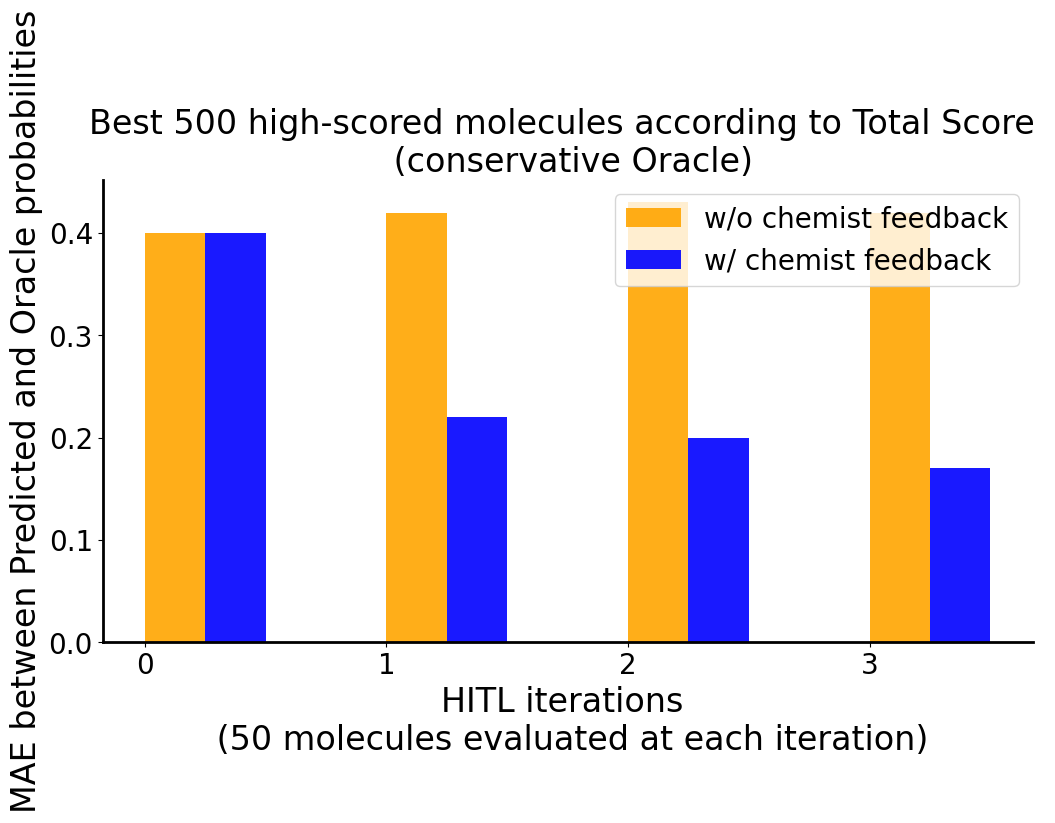

In [32]:
mae_wrt_oracle(results_chemist1, oracle_type = "conservative")

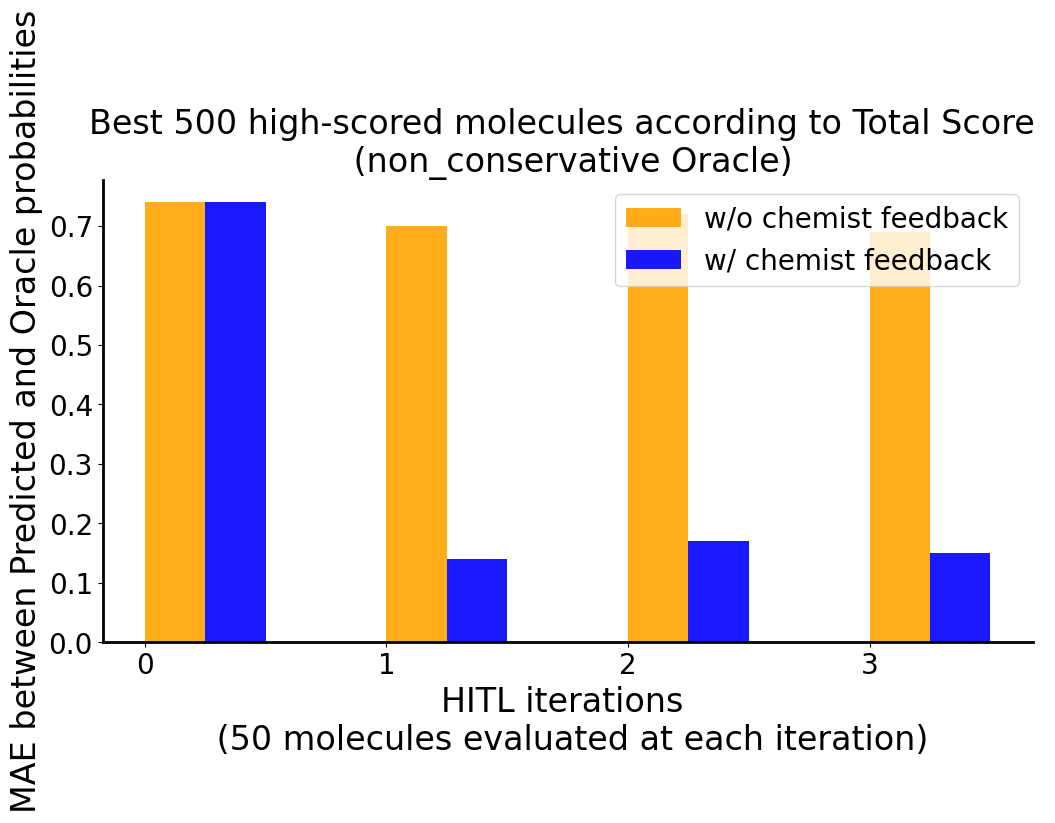

In [33]:
mae_wrt_oracle(results_chemist1, oracle_type = "non_conservative")

## Results Chemist 2

In [19]:
# Change paths
path_to_results_folder = "path/to/chemist2/results"

In [20]:
results_chemist2 = get_hitl_results(path_to_results_folder, path_to_baseline, path_to_initial_pool, top_molecules = 500)

0
1
2
3


In [21]:
results_chemist2["human_pred_score"] = 1-np.array(results_chemist2["human_pred_score"])

In [234]:
calc_total_oracle_score(results_chemist2)
calc_total_oracle_score(results_chemist2, base = True)

Mean Total Score (conservative DRD2 Oracle): 0.6704917437780595 
Mean Total Score (non conservative DRD2 Oracle): 0.6489907128107226 
Mean DRD2 Oracle Score (conservative) 0.4836290504282708 
Mean DRD2 Oracle Score (non conservative) 0.42987647300992843 
Mean DRD2 Predicted Score 0.8086200253665448 
Mean Absolute Error between Oracle (conservative) and Predicted 0.32499097493827395 
Mean Absolute Error between Oracle (non conservative) and Predicted 0.37874355235661633 
Mean hERG Score 0.9014190914358444 
Mean QED Score 0.5823624351620674 
Internal Diversity Score 0.4554738469238282 
Novelty Score 0.996 
Validity 1.0 
Uniqueness 1.0 
Synthetic Accessibility Score 2.8232518824848962
Mean Total Score (conservative DRD2 Oracle): 0.6964951909478991 
Mean Total Score (non conservative DRD2 Oracle): 0.5887051181368818 
Mean DRD2 Oracle Score (conservative) 0.5069710756069122 
Mean DRD2 Oracle Score (non conservative) 0.2374958935793685 
Mean DRD2 Predicted Score 0.9289235233068466 
Mean Abso

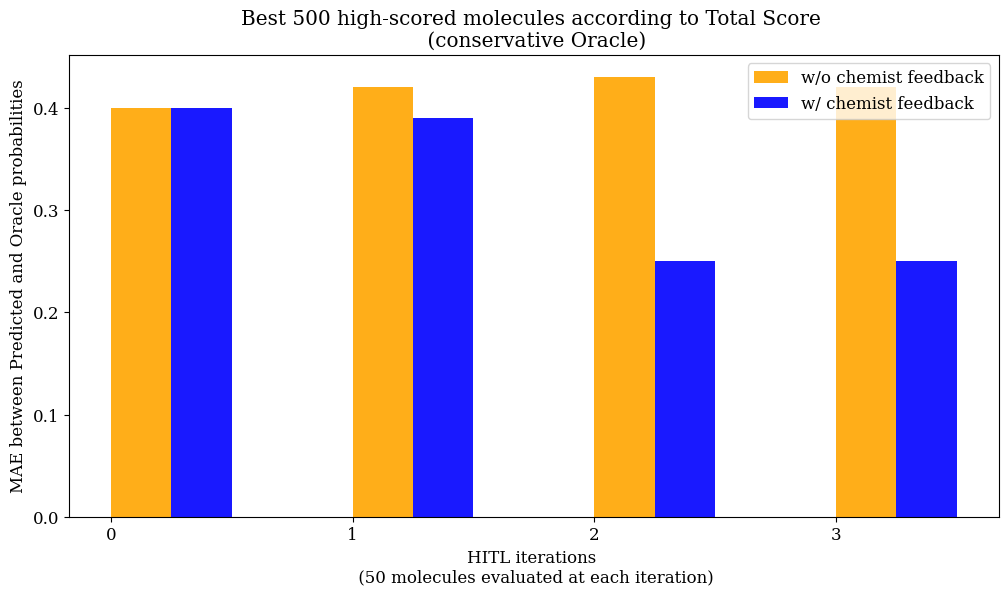

In [82]:
mae_wrt_oracle(results_chemist2, oracle_type = "conservative")

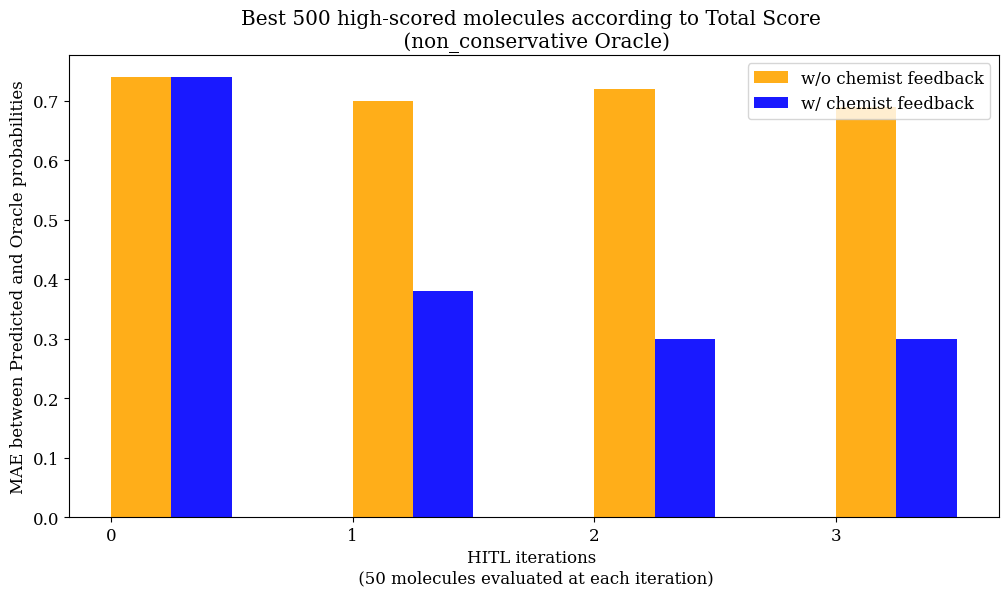

In [83]:
mae_wrt_oracle(results_chemist2, oracle_type = "non_conservative")

## Results Chemist 3

In [22]:
# Change paths
path_to_results_folder = "path/to/chemist3/results"

In [23]:
results_chemist3 = get_hitl_results(path_to_results_folder, path_to_baseline, path_to_initial_pool, top_molecules = 500)

0
1
2
3


In [24]:
results_chemist3["human_pred_score"] = [1-np.array(results_chemist3["human_pred_score"][0])] + results_chemist3["human_pred_score"][1:]

In [263]:
calc_total_oracle_score(results_chemist3)
calc_total_oracle_score(results_chemist3, base = True)

Mean Total Score (conservative DRD2 Oracle): 0.7957847359785101 
Mean Total Score (non conservative DRD2 Oracle): 0.854805577562497 
Mean DRD2 Oracle Score (conservative) 0.7635459927358915 
Mean DRD2 Oracle Score (non conservative) 0.9110980966958591 
Mean DRD2 Predicted Score 0.8724845284819605 
Mean Absolute Error between Oracle (conservative) and Predicted 0.10893853574606893 
Mean Absolute Error between Oracle (non conservative) and Predicted 0.03861356821389861 
Mean hERG Score 0.8331431349200965 
Mean QED Score 0.7855454245805741 
Internal Diversity Score 0.4188918548583984 
Novelty Score 0.992 
Validity 1.0 
Uniqueness 1.0 
Synthetic Accessibility Score 3.054187640668675
Mean Total Score (conservative DRD2 Oracle): 0.7074424412361494 
Mean Total Score (non conservative DRD2 Oracle): 0.5894682536313733 
Mean DRD2 Oracle Score (conservative) 0.5277583627934348 
Mean DRD2 Oracle Score (non conservative) 0.2328228937814947 
Mean DRD2 Predicted Score 0.9402523548603058 
Mean Absolut

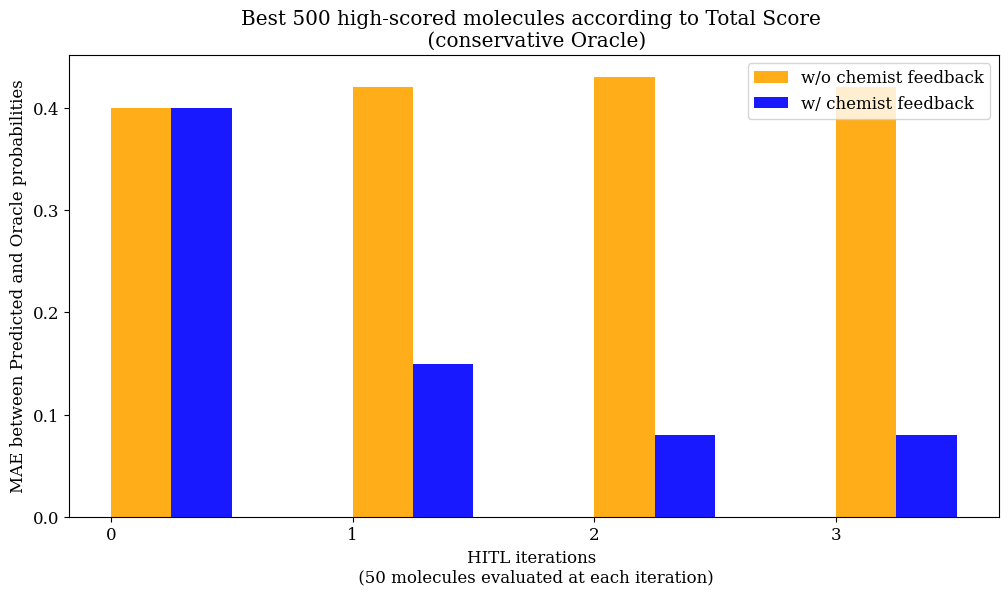

In [93]:
mae_wrt_oracle(results_chemist3, oracle_type = "conservative")

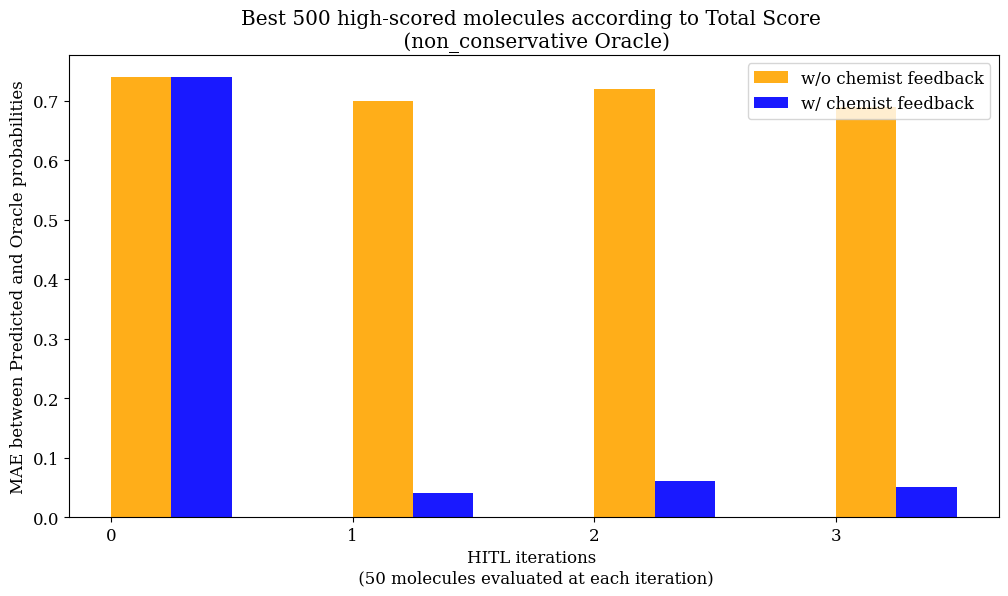

In [94]:
mae_wrt_oracle(results_chemist3, oracle_type = "non_conservative")

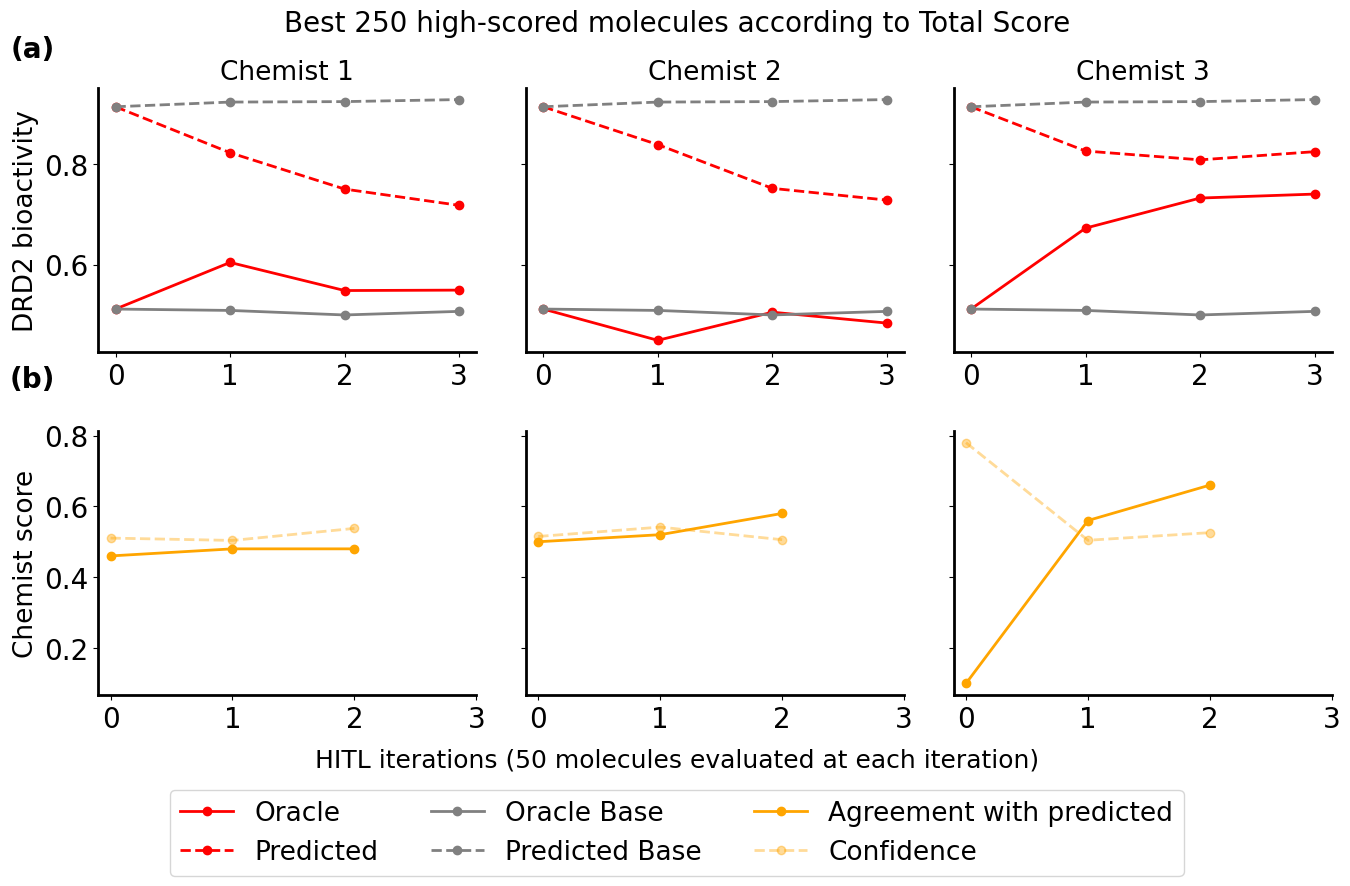

In [90]:
def plot_bars_and_lines(results, top_molecules=500, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharey="row")

    # ROW 1: Bars for Oracle and Predicted values
    for i, result in enumerate(results):
        data = np.concatenate(result["all_orc_pred"])
        data_base = np.concatenate(result["all_orc_pred_base"])
        data_pred = np.concatenate(result["all_updated_pred"])
        data_pred_base = np.concatenate(result["all_init_pred_base"])
        labels = ['0'] * len(result["all_orc_pred"][0]) + ['1'] * len(result["all_orc_pred"][1]) + ['2'] * len(
            result["all_orc_pred"][2]) + ['3'] * len(result["all_orc_pred"][3])
        labels_base = ['0'] * len(result["all_orc_pred_base"][0]) + ['1'] * len(
            result["all_orc_pred_base"][1]) + ['2'] * len(result["all_orc_pred_base"][2]) + ['3'] * len(
            result["all_orc_pred_base"][3])
        labels_pred = ['0'] * len(result["all_updated_pred"][0]) + ['1'] * len(result["all_updated_pred"][1]) + ['2'] * len(
            result["all_updated_pred"][2]) + ['3'] * len(result["all_updated_pred"][3])
        labels_pred_base = ['0'] * len(result["all_init_pred_base"][0]) + ['1'] * len(
            result["all_init_pred_base"][1]) + ['2'] * len(result["all_init_pred_base"][2]) + ['3'] * len(
            result["all_init_pred_base"][3])

        # Combine data into a single DataFrame for seaborn
        df = pd.DataFrame({'Values': data, 'Iter': labels})
        df_base = pd.DataFrame({'Values': data_base, 'Iter': labels_base})
        df_pred = pd.DataFrame({'Values': data_pred, 'Iter': labels_pred})
        df_pred_base = pd.DataFrame({'Values': data_pred_base, 'Iter': labels_pred_base})

        # Calculate means for each dataset
        means = df.groupby('Iter')['Values'].mean().values
        means_base = df_base.groupby('Iter')['Values'].mean().values
        means_pred = df_pred.groupby('Iter')['Values'].mean().values
        means_pred_base = df_pred_base.groupby('Iter')['Values'].mean().values

        # Plotting means with lines
        axes[0, i].plot(np.arange(4), means, color='red', marker='o', linestyle="-", label='Oracle')
        axes[0, i].plot(np.arange(4), means_pred, color='red', marker='o', linestyle="--", label='Predicted')
        axes[0, i].plot(np.arange(4), means_base, color='gray', marker='o', linestyle="-", label='Oracle Base')
        axes[0, i].plot(np.arange(4), means_pred_base, color='gray', marker='o', linestyle="--", label='Predicted Base')

        axes[0, i].set_title(f"Chemist {i + 1}", fontsize=19)
        if i == 0:
            axes[0, i].set_ylabel('DRD2 bioactivity', fontsize=19)

    # ROW 2: Lines for Human predictions
    for i, result in enumerate(results):
        axes[1, i].plot(np.arange(0, 3), result["human_pred"], color='orange', marker='o', label="Agreement with predicted")
        axes[1, i].plot(np.arange(0, 3), result["human_pred_score"], color='orange', marker='o', linestyle='--', alpha=0.4, label="Confidence")
        axes[1, i].set_xticks([0, 1, 2, 3])
        #axes[1, i].set_title(f"Chemist {i + 1}", fontsize=19)

        if i == 0:
            axes[1, i].set_ylabel("Chemist score", fontsize=19)

    # Combine legends for both rows
    handles_row1, labels_row1 = axes[0, 0].get_legend_handles_labels()
    handles_row2, labels_row2 = axes[1, 0].get_legend_handles_labels()
    handles_combined = handles_row1 + handles_row2
    labels_combined = labels_row1 + labels_row2
    fig.legend(handles_combined, labels_combined, loc='lower center', bbox_to_anchor=(0.5, 0.04), ncol=3, fontsize=19)

    fig.suptitle(f"Best {top_molecules} high-scored molecules according to Total Score", fontsize=20, y=0.92)
    fig.supxlabel('HITL iterations (50 molecules evaluated at each iteration)', ha='center', va='center', y=0.17, fontsize=18)

    # Add bold index labels (a) and (b)
    fig.text(0.04, 0.88, '(a)', fontsize=20, fontweight='bold', ha='center', va='center')
    fig.text(0.04, 0.55, '(b)', fontsize=20, fontweight='bold', ha='center', va='center')
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.97])  # Adjust layout to fit legends
    
    if save_path:
        # Show the plots
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches="tight")
        plt.show()

# Example usage:
plot_bars_and_lines([results_chemist1, results_chemist2, results_chemist3], top_molecules=250)

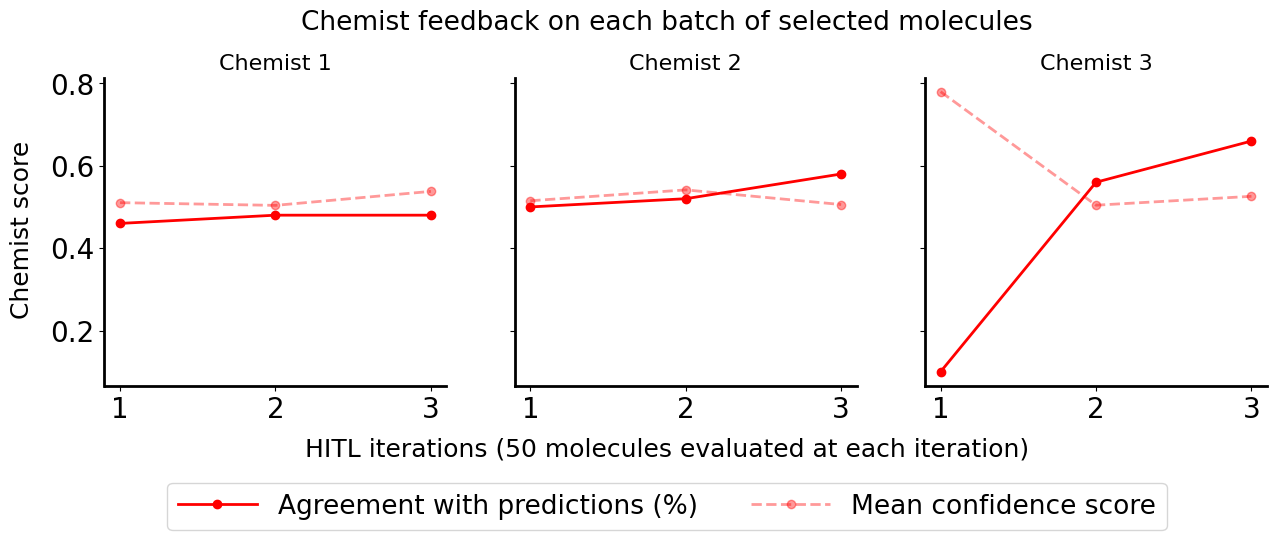

In [24]:
def plot_scores(results, top_molecules=500, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    
    all_lines = []  # Collecting lines for shared legend

    for i, result in enumerate(results):
        result["human_pred_score"] = [1-j if j < 0.5 else j for j in result["human_pred_score"]]
            
        axes[i].plot(np.arange(1,4), result["human_pred"], color='red', marker='o', label = "Agreement with predicted")
        axes[i].plot(np.arange(1,4), result["human_pred_score"], color='red', marker='o', linestyle='--', alpha=0.4, label = "Confidence")
        axes[i].set_xticks([1,2,3])
        
        axes[i].set_title(f"Chemist {i+1}", fontsize = 16)

    # Create shared legend outside of subplots with manual formatting
    legend_labels = ['Agreement with predictions (%)', 'Mean confidence score']
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', marker='o'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', alpha=0.4)
    ]

    fig.legend(legend_handles, legend_labels, handlelength = 3, fontsize = 19,
               loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)


    fig.suptitle(f"Chemist feedback on each batch of selected molecules", fontsize=19, y=1.05)
    fig.supxlabel("HITL iterations (50 molecules evaluated at each iteration)", ha="center", va="center", fontsize=18, y=-0.05)
    fig.supylabel("Chemist score", ha="center", va="center", fontsize=18, x=0.07, y=0.5)  # Adjust the 'y' parameter

    if save_path:
        # Show the plots
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches="tight")
        plt.show()

# Example usage:
plot_scores([results_chemist1, results_chemist2, results_chemist3], top_molecules=500)

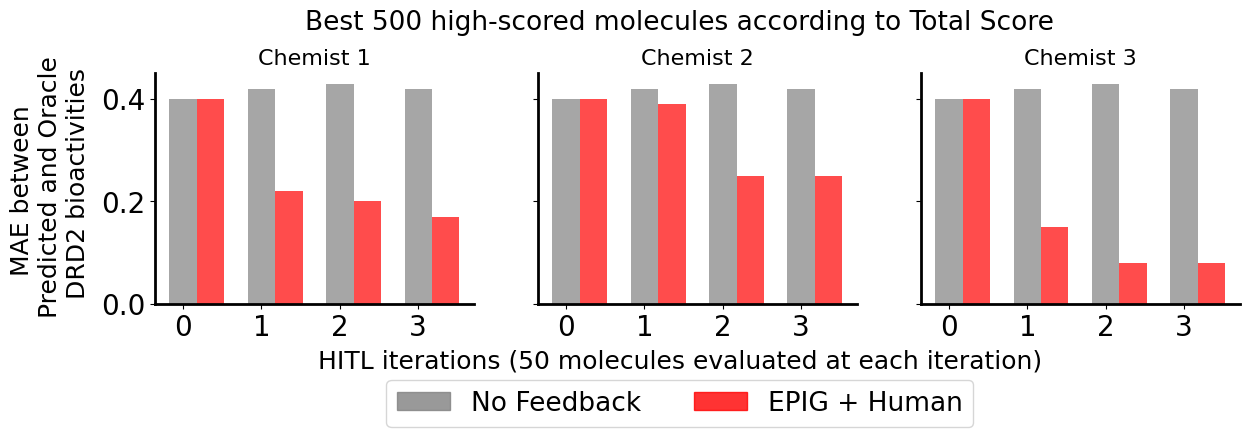

In [34]:
def plot_bars(results, top_molecules=500, oracle_type="conservative", save_path=None):
    
    labels = ["No Feedback", "EPIG + Human"]
    all_colors = ["gray", "red"]
    x = np.arange(4)
    rounds = np.arange(4)
    num_methods = 2
    bar_width = 0.35
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)

    for i, result in enumerate(results):
        
        if oracle_type == "conservative":
            no_hitl_diff = [abs(i - j) for i,j in zip(
                [result["orc_pred_base"][0], result["orc_pred_base"][1], result["orc_pred_base"][2], result["orc_pred_base"][-1]], 
                [result["init_pred_base"][0], result["init_pred_base"][1], result["init_pred_base"][2], result["init_pred_base"][-1]]
            )]
            hitl_diff = [abs(i - j) for i,j in zip(
                [result["orc_pred"][0], result["orc_pred"][1], result["orc_pred"][2], result["orc_pred"][-1]], 
                [result["updated_pred"][0], result["updated_pred"][1], result["updated_pred"][2], result["updated_pred"][-1]]
            )]
        if oracle_type == "non_conservative":
            no_hitl_diff = [abs(i - j) for i,j in zip(
                [result["orc_tdc_base"][0], result["orc_tdc_base"][1], result["orc_tdc_base"][2], result["orc_tdc_base"][-1]], 
                [result["init_pred_base"][0], result["init_pred_base"][1], result["init_pred_base"][2], result["init_pred_base"][-1]]
            )]
            hitl_diff = [abs(i - j) for i,j in zip(
                [result["orc_tdc"][0], result["orc_tdc"][1], result["orc_tdc"][2], result["orc_tdc"][-1]], 
                [result["updated_pred"][0], result["updated_pred"][1], result["updated_pred"][2], result["updated_pred"][-1]]
            )]

        vals = [np.round(no_hitl_diff,2), np.round(hitl_diff,2)]  

        # Create bars for each method in data1 and add error bars
        for j, v in enumerate(vals):
            axes[i].bar(
                rounds + (j + 1) * bar_width,
                v,
                width=bar_width,
                label=labels[j],
                alpha=0.7,
                color=all_colors[j],
            )
        
        axes[i].set_title(f"Chemist {i+1}", fontsize=16)
        
        # Set custom x ticks for each subplot
        axes[i].set_xticks(rounds + bar_width * (num_methods / 2))
        axes[i].set_xticklabels(rounds)
        
    # Create shared legend outside of subplots with manual formatting
    legend_handles = [
        Patch(color='gray', alpha=0.8),
        Patch(color='red', alpha=0.8)
    ]

    fig.legend(legend_handles, labels, fontsize=19,
               loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

    fig.suptitle(f"Best {top_molecules} high-scored molecules according to Total Score", fontsize=19, y=1.09)
    fig.supxlabel("HITL iterations (50 molecules evaluated at each iteration)", ha="center", va="center", fontsize=18, y=-0.08)
    fig.supylabel("MAE between \n Predicted and Oracle \n DRD2 bioactivities", ha="center", va="center", fontsize=18, x=0.05, y=0.5)

    if save_path:
        # Show the plots
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches="tight")
        plt.show()

# Example usage:
plot_bars([results_chemist1, results_chemist2, results_chemist3], top_molecules=500)

1
2
3


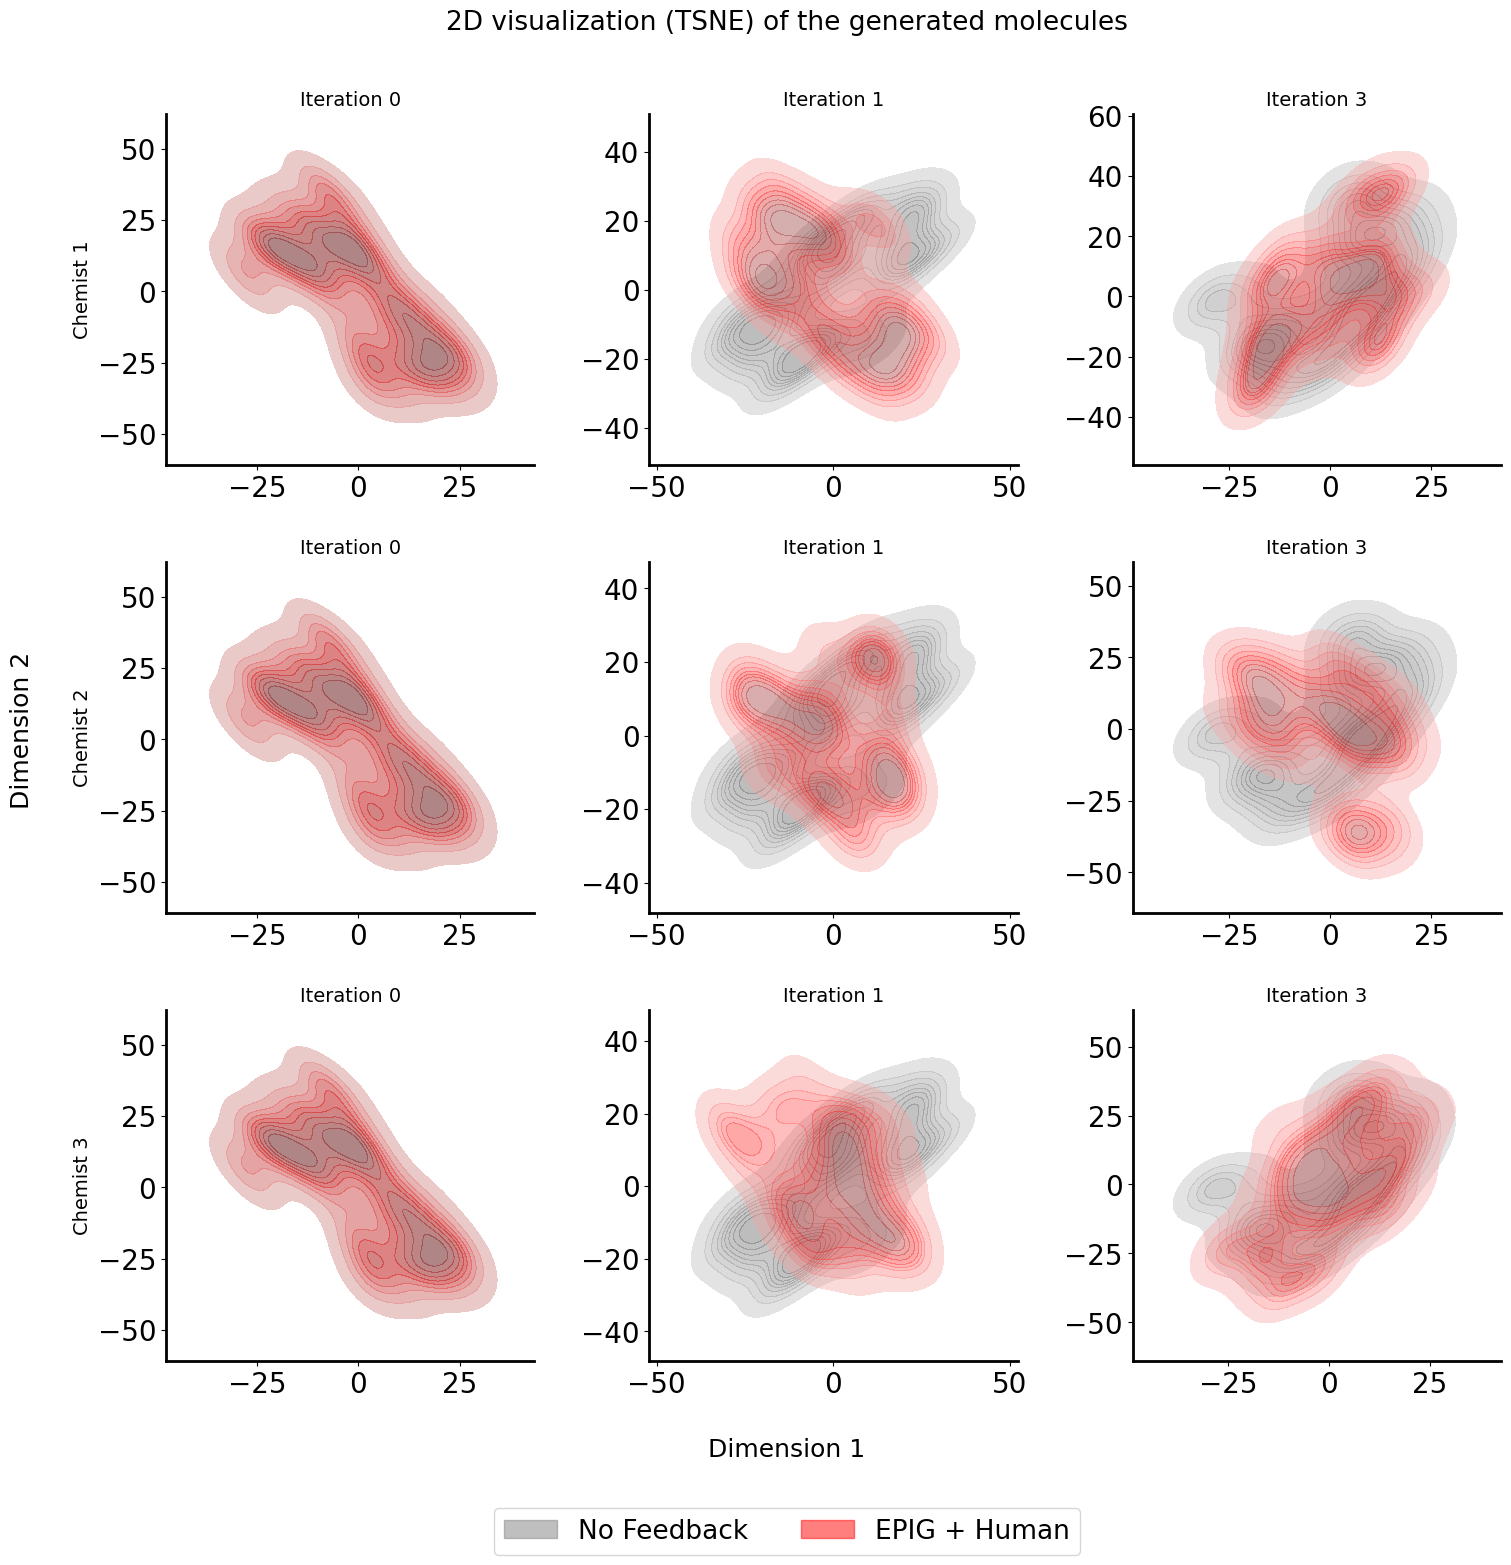

In [24]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

chembl_sample = pd.read_csv(f"{chemspace}/chembl.csv", sep=",", index_col=0)

def calculate_fingerprints(smiles_list):
    """Calculate molecular fingerprints for a dataframe."""
    fingerprints = fp_counter.get_fingerprints(smiles_list)
    return fingerprints

def fit_dimensionality_reduction_model(fingerprints, method='tsne'):
    """Fit t-SNE or PCA on a sample."""
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid dimensionality reduction method. Choose 'tsne' or 'pca'.")
    
    # Fit the model on a sample
    reducer.fit_transform(fingerprints)  # Adjust the sample size as needed
    return reducer

def reduce_dimensions_with_model(fingerprints, reducer):
    """Reduce dimensions using a pre-fit t-SNE or PCA model."""
    reduced_data = reducer.fit_transform(fingerprints)
    return reduced_data

def plot_chemical_space(
    smiles_lists1, base_smiles_lists1, 
    smiles_lists2, base_smiles_lists2,
    smiles_lists3, base_smiles_lists3,
    reduction_method='tsne',
    save_path=None
):
    
    smiles_lists1 = [smiles_lists1[0], smiles_lists1[1], smiles_lists1[-1]]
    base_smiles_lists1 = [base_smiles_lists1[0], base_smiles_lists1[1], base_smiles_lists1[-1]]
    
    smiles_lists2 = [smiles_lists2[0], smiles_lists2[1], smiles_lists2[-1]]
    base_smiles_lists2 = [base_smiles_lists2[0], base_smiles_lists2[1], base_smiles_lists2[-1]]
    
    smiles_lists3 = [smiles_lists3[0], smiles_lists3[1], smiles_lists3[-1]]
    base_smiles_lists3 = [base_smiles_lists3[0], base_smiles_lists3[1], base_smiles_lists3[-1]]
    
    sample_fps = calculate_fingerprints(chembl_sample.SMILES.tolist())
    dimensionality_reduction_model = fit_dimensionality_reduction_model(sample_fps, method=reduction_method)
    
    """Plot 2D visualizations of the chemical space for molecules with and without chemist feedback."""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    print(1)

    for i, (smiles_list, base_smiles_list) in enumerate(zip(smiles_lists1, base_smiles_lists1)):

        fps = calculate_fingerprints(smiles_list)
        base_fps = calculate_fingerprints(base_smiles_list)

        # Reduce dimensions
        reduced_fps = reduce_dimensions_with_model(fps, dimensionality_reduction_model)
        reduced_base_fps = reduce_dimensions_with_model(base_fps, dimensionality_reduction_model)

        # Convert reduced fingerprints to DataFrame for seaborn
        data = pd.DataFrame(reduced_fps, columns=['Dimension 1', 'Dimension 2'])
        base_data = pd.DataFrame(reduced_base_fps, columns=['Dimension 1', 'Dimension 2'])

        # Plot density plots with transparency
        sns.kdeplot(data=base_data, x="Dimension 1", y="Dimension 2", ax=axes[0,i], color="gray", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)
        sns.kdeplot(data=data, x="Dimension 1", y="Dimension 2", ax=axes[0,i], color="red", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)
        
        if i == 0 or i == 1:
            axes[0,i].set_title(f"Iteration {i}", fontsize=14)
        else:
            axes[0,i].set_title(f"Iteration {i+1}", fontsize=14)
        axes[0,0].set_ylabel(f"Chemist 1", fontsize=14)
        axes[0,1].set_ylabel(None)
        axes[0,2].set_ylabel(None)
        axes[0,i].set_xlabel(None)
        
    print(2)
        
    for i, (smiles_list, base_smiles_list) in enumerate(zip(smiles_lists2, base_smiles_lists2)):

        fps = calculate_fingerprints(smiles_list)
        base_fps = calculate_fingerprints(base_smiles_list)

        # Reduce dimensions
        reduced_fps = reduce_dimensions_with_model(fps, dimensionality_reduction_model)
        reduced_base_fps = reduce_dimensions_with_model(base_fps, dimensionality_reduction_model)

        # Convert reduced fingerprints to DataFrame for seaborn
        data = pd.DataFrame(reduced_fps, columns=['Dimension 1', 'Dimension 2'])
        base_data = pd.DataFrame(reduced_base_fps, columns=['Dimension 1', 'Dimension 2'])

        # Plot density plots with transparency
        sns.kdeplot(data=base_data, x="Dimension 1", y="Dimension 2", ax=axes[1,i], color="gray", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)
        sns.kdeplot(data=data, x="Dimension 1", y="Dimension 2", ax=axes[1,i], color="red", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)

        if i == 0 or i == 1:
            axes[1,i].set_title(f"Iteration {i}", fontsize=14)
        else:
            axes[1,i].set_title(f"Iteration {i+1}", fontsize=14)
        axes[1,0].set_ylabel(f"Chemist 2", fontsize=14)
        axes[1,1].set_ylabel(None)
        axes[1,2].set_ylabel(None)
        axes[1,i].set_xlabel(None)
        
    print(3)
    
    for i, (smiles_list, base_smiles_list) in enumerate(zip(smiles_lists3, base_smiles_lists3)):

        fps = calculate_fingerprints(smiles_list)
        base_fps = calculate_fingerprints(base_smiles_list)

        # Reduce dimensions
        reduced_fps = reduce_dimensions_with_model(fps, dimensionality_reduction_model)
        reduced_base_fps = reduce_dimensions_with_model(base_fps, dimensionality_reduction_model)

        # Convert reduced fingerprints to DataFrame for seaborn
        data = pd.DataFrame(reduced_fps, columns=['Dimension 1', 'Dimension 2'])
        base_data = pd.DataFrame(reduced_base_fps, columns=['Dimension 1', 'Dimension 2'])

        # Plot density plots with transparency
        sns.kdeplot(data=base_data, x="Dimension 1", y="Dimension 2", ax=axes[2,i], color="gray", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)
        sns.kdeplot(data=data, x="Dimension 1", y="Dimension 2", ax=axes[2,i], color="red", fill=True, alpha=0.4, linewidth=0, edgecolor=None, common_norm=False)

        if i == 0 or i == 1:
            axes[2,i].set_title(f"Iteration {i}", fontsize=14)
        else:
            axes[2,i].set_title(f"Iteration {i+1}", fontsize=14)
        axes[2,0].set_ylabel(f"Chemist 3", fontsize=14)
        axes[2,1].set_ylabel(None)
        axes[2,2].set_ylabel(None)
        axes[2,i].set_xlabel(None)
        
    # Create shared legend outside of subplots with manual formatting
    legend_handles = [
        Patch(color='gray', alpha=0.5),
        Patch(color='red', alpha=0.5)
    ]
    
    fig.legend(legend_handles, ['No Feedback', 'EPIG + Human'], fontsize=19,
               loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)

    # Adjust layout to avoid clipping of titles
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig.supxlabel("Dimension 1", ha="center", va="center", fontsize=18, y=0.02)
    fig.supylabel("Dimension 2", ha="center", va="center", fontsize=18, x=-0.01, y=0.5)  # Adjust the 'y' parameter
    fig.suptitle(f"2D visualization ({reduction_method.upper()}) of the generated molecules", fontsize=19)
    
    if save_path:
        # Show the plots
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches="tight")
        plt.show()

# Example usage:
plot_chemical_space(
    results_chemist1["outputs_smiles"], results_chemist1["outputs_base_smiles"],
    results_chemist2["outputs_smiles"], results_chemist2["outputs_base_smiles"],
    results_chemist3["outputs_smiles"], results_chemist3["outputs_base_smiles"],
    reduction_method='tsne'
)

#### Statistical analysis of significance

In [156]:
from scipy.stats import f_oneway

def anova_test(group1, group2):

    # Performing ANOVA test
    statistic, p_value = f_oneway(group1, group2)

    # Output results
    #print(f"ANOVA Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Check significance level (commonly set at 0.05)
    alpha = 0.05
    if p_value < alpha:
        print(f"(*) {p_value} < {alpha}. Reject the null hypothesis. There is a significant difference.")
    else:
        print(f"{p_value} > {alpha}. Fail to reject the null hypothesis. No significant difference.")
        
    alpha2 = 0.01
    if p_value < alpha2:
        print(f"(**) {p_value} < {alpha2}. Reject the null hypothesis. There is a significant difference.")
    else:
        print(f"{p_value} > {alpha2}. Fail to reject the null hypothesis. No significant difference.")

In [97]:
anova_test(results_chemist1["all_orc_pred"][-1], results_chemist1["all_orc_pred_base"][-1])

P-value: 2.1917318439261558e-07
2.1917318439261558e-07 < 0.05. Reject the null hypothesis. There is a significant difference.


In [98]:
anova_test(results_chemist2["all_orc_pred"][-1], results_chemist2["all_orc_pred_base"][-1])

P-value: 0.014543702047676223
0.014543702047676223 < 0.05. Reject the null hypothesis. There is a significant difference.


In [99]:
anova_test(results_chemist3["all_orc_pred"][-1], results_chemist3["all_orc_pred_base"][-1])

P-value: 2.445351076946317e-146
2.445351076946317e-146 < 0.05. Reject the null hypothesis. There is a significant difference.


In [27]:
anova_test(results_chemist3["all_qed"][-1], results_chemist3["all_qed_base"][-1])

P-value: 4.2549818184303066e-94
4.2549818184303066e-94 < 0.05. Reject the null hypothesis. There is a significant difference.


In [30]:
anova_test(results_chemist3["all_init_pred_base"][-1], results_chemist3["all_updated_pred"][-1])

P-value: 5.001924450176966e-265
5.001924450176966e-265 < 0.05. Reject the null hypothesis. There is a significant difference.


In [38]:
err_base = np.array(results_chemist1["all_init_pred_base"][-1]) - np.array(results_chemist1["all_orc_pred_base"][-1])
err = np.array(results_chemist1["all_updated_pred"][-1]) - np.array(results_chemist1["all_orc_pred"][-1])

anova_test(err, err_base)

P-value: 5.336392395899895e-156
5.336392395899895e-156 < 0.05. Reject the null hypothesis. There is a significant difference.


In [39]:
err_base = np.array(results_chemist2["all_init_pred_base"][-1]) - np.array(results_chemist2["all_orc_pred_base"][-1])
err = np.array(results_chemist2["all_updated_pred"][-1]) - np.array(results_chemist2["all_orc_pred"][-1])

anova_test(err, err_base)

P-value: 7.454862388497572e-70
7.454862388497572e-70 < 0.05. Reject the null hypothesis. There is a significant difference.


In [40]:
err_base = np.array(results_chemist3["all_init_pred_base"][-1]) - np.array(results_chemist3["all_orc_pred_base"][-1])
err = np.array(results_chemist3["all_updated_pred"][-1]) - np.array(results_chemist3["all_orc_pred"][-1])

anova_test(err, err_base)

P-value: 1.3820610234301786e-250
1.3820610234301786e-250 < 0.05. Reject the null hypothesis. There is a significant difference.


In [185]:
def percentage_lipinski_mollogp(smiles_list):
    """
    Calculate the percentage of SMILES molecules that respect the Lipinski Rule of Five for MolLogP.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    float: Percentage of SMILES molecules that pass the Lipinski MolLogP rule.
    """
    valid_molecules = 0
    passing_molecules = 0
    mol_logp_values = []
    mol_passing_values = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            valid_molecules += 1
            mol_logp = Descriptors.MolLogP(mol)
            mol_logp_values.append(mol_logp)
            if mol_logp < 3:
                passing_molecules += 1
                mol_passing_values.append(1)
            else:
                mol_passing_values.append(0) 
    
    if valid_molecules == 0:
        return 0.0
    
    return (passing_molecules / valid_molecules), np.mean(mol_logp_values), np.std(mol_logp_values), mol_passing_values

Percentage of SMILES that pass the Lipinski MolLogP Rule: 1.0


In [186]:
percentage, mean_logp, std_logp, mol_logp_values_chemist1 = percentage_lipinski_mollogp(results_chemist1['outputs_smiles'][-1])
print(percentage)
print(mean_logp, std_logp)

0.544
2.922176560000002 0.8731915521005503


In [187]:
percentage, mean_logp, std_logp, mol_logp_values_chemist2 = percentage_lipinski_mollogp(results_chemist2['outputs_smiles'][-1])
print(percentage)
print(mean_logp, std_logp)

0.788
2.5644879400000007 0.5506110314568323


In [194]:
percentage, mean_logp, std_logp, mol_logp_values_chemist3 = percentage_lipinski_mollogp(results_chemist3['outputs_smiles'][-1])
print(percentage)
print(mean_logp, std_logp)

0.66
2.7309948800000012 0.7664193616913572


In [193]:
percentage, mean_logp, std_logp, mol_logp_values_base = percentage_lipinski_mollogp(results_chemist3['outputs_base_smiles'][-1])
print(percentage)
print(mean_logp, std_logp)

0.7
2.4636111000000014 0.8867926388279225
